In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
data = pd.read_csv("final_10minutes.csv")
data.drop(['Month'], axis =1, inplace= True)
#data.set_index("time", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['Unnamed: 0',  'green', 'yellow', 'total'], axis =1, inplace = True)

In [3]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

In [4]:
#normalize data & make LSTM model structure
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [5]:
# exlcude significantly deviated data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3*6:, -1])
n_p = n_p + 365*24*3*6

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 6 + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [6]:
# split into train and test sets 
n_train_hours = 365 * 24 * 3 * 6
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(157680, 235) 157680 (157680,)
(157680, 47, 5) (157680,) (39355, 47, 5) (39355,)


In [7]:
from keras.layers import merge
from keras.layers.core import *
from keras.models import *

In [9]:
def attention_3d_block(inputs):
    INPUT_DIM = 5
    TIME_STEPS = 47
    SINGLE_ATTENTION_VECTOR = False
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

In [9]:
def model_attention_applied_after_lstm():
    INPUT_DIM = 5
    TIME_STEPS = 47
    
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 24
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [9]:
def model_attention_applied_after_before_lstm():
    INPUT_DIM = 5
    TIME_STEPS = 47
    
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 24
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = LSTM(lstm_units)(attention_mul)
    output = Dense(1)(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [10]:
m = model_attention_applied_after_before_lstm()
m.compile(loss='mae', optimizer='adam')
history = m.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Train on 157680 samples, validate on 39355 samples
Epoch 1/100
 - 140s - loss: 0.0543 - val_loss: 0.0323
Epoch 2/100
 - 138s - loss: 0.0226 - val_loss: 0.0218
Epoch 3/100
 - 138s - loss: 0.0156 - val_loss: 0.0145
Epoch 4/100
 - 136s - loss: 0.0133 - val_loss: 0.0125
Epoch 5/100
 - 137s - loss: 0.0122 - val_loss: 0.0119
Epoch 6/100
 - 137s - loss: 0.0115 - val_loss: 0.0114
Epoch 7/100
 - 137s - loss: 0.0112 - val_loss: 0.0111
Epoch 8/100
 - 136s - loss: 0.0110 - val_loss: 0.0105
Epoch 9/100
 - 137s - loss: 0.0107 - val_loss: 0.0099
Epoch 10/100
 - 137s - loss: 0.0106 - val_loss: 0.0094
Epoch 11/100
 - 137s - loss: 0.0102 - val_loss: 0.0091
Epoch 12/100
 - 136s - loss: 0.0102 - val_loss: 0.0089
Epoch 13/100
 - 137s - loss: 0.0101 - val_loss: 0.0088
Epoch 14/100
 - 137s - loss: 0.0100 - val_loss: 0.0089
Epoch 15/100
 - 137s - loss: 0.0098 - val_loss: 0.0090
Epoch 16/100
 - 136s - loss: 0.0097 - val_loss: 0.0089
Epoch 17/100
 - 136s - loss: 0.0096 - val_loss: 0.0089
Epoch 18/100
 - 137s - 

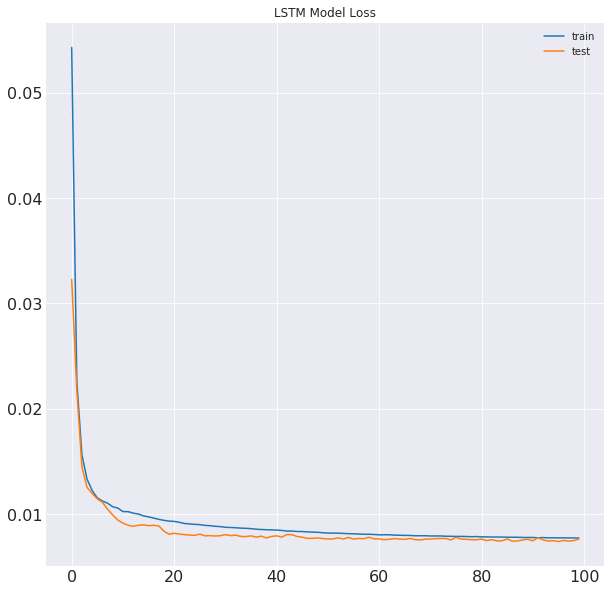

In [11]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [12]:
# make a prediction 
yhat = m.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 235:239], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 235:239], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9914393619753809
MAE:  73.35369
RMSE: 102.75157769470015
mean absolute error percentage:  3.8349203765392303


In [13]:
#train error(bias)
yhat_t = m.predict(train_X)
# reshape back to 2d
train_X = train_X.reshape((train_X.shape[0], -1))

# invert scaling for forecast
inv_yhat_t = np.concatenate((train[:, 235:239], yhat_t), axis=1)
inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
inv_yhat_t = inv_yhat_t[:,-1]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y_t = np.concatenate((train[:, 235:239], train_y), axis=1)
inv_y_t = scaler.inverse_transform(inv_y_t)
inv_y_t = inv_y_t[:,-1]
inv_yhat_gte_zero = inv_yhat_t.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# exlcude significantly deviated data
index = (np.abs((inv_y_t - inv_yhat_t)/inv_y_t) < 1)

# calculate r2
print("R2:  ", r2_score(inv_y_t[index], inv_yhat_t[index]))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y_t[index], inv_yhat_t[index]))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_t[index], inv_yhat_t[index]))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y_t[index] - inv_yhat_t[index])/inv_y_t[index]))*100
print("mean absolute error percentage: ", maep)

R2:   0.9888042883127799
MAE:  109.87407
RMSE: 151.78845270639002
mean absolute error percentage:  3.701294958591461


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
